import library

In [1]:
import numpy as np
import pandas as pd
import collections
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

Read the data. Below is the first 5 rows of the data. The column 'behavior' can have 4 value {'pv','fav','cart','buy'} corresponding for 4 actions visit, favour, add to cart and buy.

In [2]:
ratings = pd.read_csv("UserBehavior.csv",dtype={'user_id':int, 'item_id':int, 'category_id':int, 'behavior':str, 'timestamp':np.int64})
print(ratings.head())
ratings.describe()

   user_id  item_id  category_id behavior   timestamp
0        1  2268318      2520377       pv  1511544070
1        1  2333346      2520771       pv  1511561733
2        1  2576651       149192       pv  1511572885
3        1  3830808      4181361       pv  1511593493
4        1  4365585      2520377       pv  1511596146


,user_id,item_id,category_id,timestamp
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,9.124134e+05,2.578439e+06,2.706415e+06,1.511962e+09
std,2.727758e+05,1.487995e+06,1.464783e+06,2.293642e+05
min,1.000000e+00,2.830000e+02,2.171000e+03,1.505118e+09
25%,1.000723e+06,1.295192e+06,1.331853e+06,1.511768e+09
50%,1.001908e+06,2.577764e+06,2.733371e+06,1.511965e+09
75%,1.003157e+06,3.864858e+06,4.145813e+06,1.512175e+09
max,1.004381e+06,5.163001e+06,5.158474e+06,1.512317e+09


Calculate percentage of each behavior

In [3]:
behavior_counts = ratings['behavior'].value_counts()
behavior_percents = behavior_counts / len(ratings) * 100
print(behavior_percents)

pv      89.709
cart     5.446
fav      2.744
buy      2.101
Name: behavior, dtype: float64


I encode each type of behavior to a specific real number in  [0;1] and store the score in column 'score'.

In [4]:
# Convert behavior types to scores
behavior_scores = {'pv': 0.02, 'fav': 0.5, 'cart': 0.3, 'buy': 0.9}
ratings['score'] = ratings['behavior'].map(behavior_scores)
ratings.head()

,user_id,item_id,category_id,behavior,timestamp,score
0,1,2268318,2520377,pv,1511544070,0.02
1,1,2333346,2520771,pv,1511561733,0.02
2,1,2576651,149192,pv,1511572885,0.02
3,1,3830808,4181361,pv,1511593493,0.02
4,1,4365585,2520377,pv,1511596146,0.02


In [5]:
ratings = ratings.groupby(['user_id', 'item_id'])['score'].sum().reset_index()
ratings[1:40]

,user_id,item_id,score
1,1,79715,0.02
2,1,230380,0.02
3,1,266784,0.04
4,1,271696,0.02
5,1,568695,0.02
6,1,818610,0.02
7,1,929177,0.02
8,1,1305059,0.02
9,1,1323189,0.02
10,1,1338525,0.02


Create a mapping from real user_id and item_id to consecutive_user_id and consecutive_item_id (1....num users/items)

In [6]:
#`ratings` is a pandas dataframe with columns 'user_id', 'item_id', and 'score'
user_ids = ratings['user_id'].unique()
item_ids = ratings['item_id'].unique()

# Create a mapping of original IDs to consecutive IDs for users and items
user_id_map = pd.Series(np.arange(len(user_ids)), index=user_ids)
item_id_map = pd.Series(np.arange(len(item_ids)), index=item_ids)

# Map the original user and item IDs to consecutive IDs
ratings['consecutive_user_id'] = user_id_map[ratings['user_id']].values
ratings['consecutive_item_id'] = item_id_map[ratings['item_id']].values
ratings


,user_id,item_id,score,consecutive_user_id,consecutive_item_id
0,1,46259,0.04,0,0
1,1,79715,0.02,0,1
2,1,230380,0.02,0,2
3,1,266784,0.04,0,3
4,1,271696,0.02,0,4
...,...,...,...,...,...
75719,1004381,4835134,0.02,982,2134
75720,1004381,4845368,0.02,982,48705
75721,1004381,4988513,0.02,982,28819
75722,1004381,4995608,0.02,982,21087


Create user-item matriuser_item_matrix

In [7]:
# Sum up all scores of a user
user_scores = ratings.groupby(['consecutive_user_id', 'consecutive_item_id'])['score'].sum()
# Create a user-item matrix
user_item_matrix = user_scores.unstack()
num_users, num_items = user_item_matrix.shape
num_users, num_items
user_item_matrix
user_item_matrix.shape

(983, 64467)

In [8]:
user_item_matrix

consecutive_item_id,0,1,2,3,4,5,6,7,8,9,...,64457,64458,64459,64460,64461,64462,64463,64464,64465,64466
consecutive_user_id,,,,,,,,,,,,,,,,,,,,,
0,0.04,0.02,0.02,0.04,0.02,0.02,0.02,0.02,0.02,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#calculate percentage of non-nan values in user-item matrix
num_non_nan = np.count_nonzero(~np.isnan(user_item_matrix))
num_non_nan / (num_users * num_items) * 100

0.11949302852922095

In [10]:
#copy user-item matrix
user_item_matrix_copy = user_item_matrix.copy()
#fill all nan values with the row's mean
user_item_matrix_copy = user_item_matrix_copy.apply(lambda row: row.fillna(row.mean()), axis=1)
#subtract the row's mean from each value
user_item_matrix_copy = user_item_matrix_copy.apply(lambda row: row - row.mean(), axis=1)
user_item_matrix_copy

consecutive_item_id,0,1,2,3,4,5,6,7,8,9,...,64457,64458,64459,64460,64461,64462,64463,64464,64465,64466
consecutive_user_id,,,,,,,,,,,,,,,,,,,,,
0,1.608696e-02,-3.913043e-03,-3.913043e-03,1.608696e-02,-3.913043e-03,-3.913043e-03,-3.913043e-03,-3.913043e-03,-3.913043e-03,-3.913043e-03,...,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18
1,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,...,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17,-8.326673e-17
2,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,...,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17,5.551115e-17
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,...,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17,2.775558e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
979,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
980,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,...,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18,6.938894e-18


In [11]:
#find row and column vector have less than 5 non-zero values
row_vector = user_item_matrix_copy.apply(lambda row: np.count_nonzero(row), axis=1)
col_vector = user_item_matrix_copy.apply(lambda col: np.count_nonzero(col), axis=0)
#print number of rows and columns that have less than 3 non-zero values
print('Number of rows with less than 5 non-zero values:', len(row_vector[row_vector < 5]))
print('Number of columns with less than 5 non-zero values:', len(col_vector[col_vector <5]))

Number of rows with less than 5 non-zero values: 0
Number of columns with less than 5 non-zero values: 0


In [12]:
def split_matrix(matrix, test_ratio=0.2):
    num_rows, num_cols = matrix.shape
    train = np.zeros((num_rows, num_cols))
    test = np.zeros((num_rows, num_cols))
    for i in range(num_cols):
        #find indices of non-zero elements
        indices = matrix[:, i].nonzero()[0]
        if len(indices) < 3:
            continue
        test_size = int(len(indices) * test_ratio)
        test_idx = np.random.choice(indices, test_size, replace=False)
        test[test_idx, i] = matrix[test_idx, i]
        train[:, i] = matrix[:, i]
        train[test_idx, i] = 0
    return train, test

In [13]:
def build_rating_sparse_tensor(matrix):
    """
    Args:
        matrix: A 2D numpy array representing the user-item matrix.
        
    Returns:
        a tf.SparseTensor representing the ratings matrix.
    """
    # Find the indices of the non-zero elements in the matrix
    row_indices, col_indices = np.nonzero(matrix)
    
    # Get the non-zero values in the matrix
    values = matrix[row_indices, col_indices]
    
    # Compute the number of users and items in the matrix
    num_users = matrix.shape[0]
    num_items = matrix.shape[1]
    
    # Create a SparseTensorValue object
    sparse_tensor_value = tf.SparseTensorValue(
        indices=np.array([row_indices, col_indices]).T,
        values=values,
        dense_shape=[num_users, num_items]
    )
    
    
    return sparse_tensor_value

In [14]:
def sparse_root_mean_square_error(r,u,v):
  """
  Args:
    r: A SparseTensor rating matrix, of dense_shape [N, M]
    u: A dense Tensor U such that U_i is the embedding of user i.
    v: A dense Tensor V such that V_j is the embedding of item j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # Compute the predicted tensor
  uv = tf.matmul(u, v, transpose_b=True)
  
  # Get the indices and values of the non-zero elements in r
  indices = r.indices
  values = r.values
  
  # Extract the corresponding elements from the predicted tensor
  pred_values = tf.gather_nd(uv, indices)
  
  # Compute the mean squared error of the non-zero elements
  mse = tf.reduce_mean(tf.square(values - pred_values))
  
  # Compute the root mean squared error
  rmse = tf.sqrt(mse)
  
  return rmse

In [15]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=30, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.AdamOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [16]:
#@title Solution
def build_model(train_ratings,test_ratings, embedding_dim=40, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_root_mean_square_error(A_train, U, V)
  test_loss = sparse_root_mean_square_error(A_test, U, V)
  metrics = {
      'train_rmse': train_loss,
      'test_rmse': test_loss
  }
  embeddings = {
      "user_id": U,
      "item_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [17]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    train_ratings,test_ratings, embedding_dim=30, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_root_mean_square_error(A_train, U, V)
  error_test = sparse_root_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_rmse_error_observed': error_train,
      'test_rmse_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "item_id": V}

  return CFModel(embeddings, total_loss, [losses,loss_components])

In [25]:
from sklearn.metrics import mean_squared_error
train_matrix, test_matrix = split_matrix(user_item_matrix_copy.values)
print(mean_squared_error(train_matrix, user_item_matrix_copy.values))
print(mean_squared_error(test_matrix, user_item_matrix_copy.values))
print(mean_squared_error(train_matrix, test_matrix))

9.718092204512616e-06
3.660021060499416e-05
4.6318302809506784e-05


 iteration 80: train_rmse=0.005845, test_rmse=0.009987

[{'train_rmse': 0.0058451057, 'test_rmse': 0.009986718}]

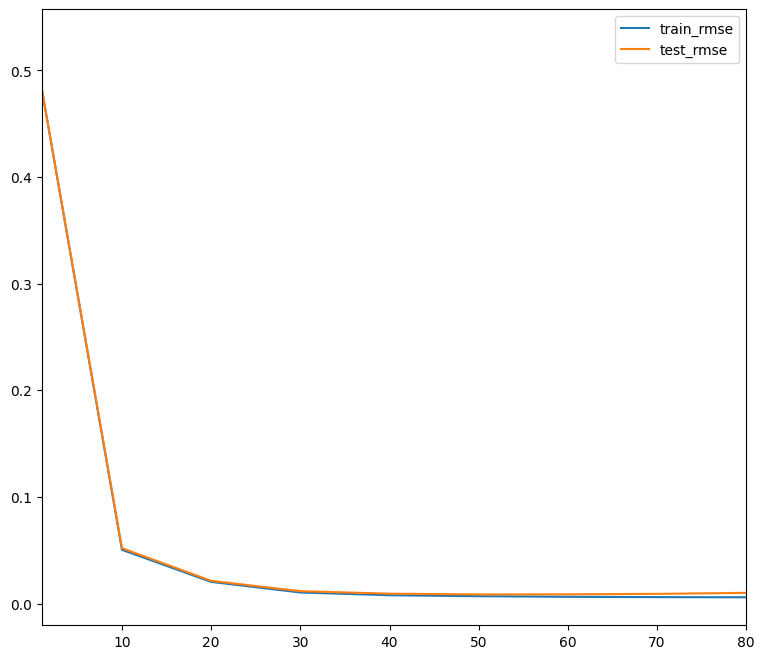

In [24]:
model = build_model(train_matrix,test_matrix, embedding_dim=35, init_stddev=0.3)
model.train(num_iterations=80, learning_rate=0.2)

In [27]:
reg_model = build_regularized_model(train_matrix,test_matrix,regularization_coeff=0.05, gravity_coeff=0.05, embedding_dim=40,init_stddev=.3)
reg_model.train(num_iterations=60, learning_rate=0.2)

MemoryError: bad allocation

 k = 3, RMSE on train: 0.008048, test: 0.008252
 k = 6, RMSE on train: 0.007922, test: 0.008152
 k = 9, RMSE on train: 0.007883, test: 0.008126
 k = 12, RMSE on train: 0.007861, test: 0.008115
 k = 15, RMSE on train: 0.007848, test: 0.008109
 k = 18, RMSE on train: 0.007839, test: 0.008104
 k = 21, RMSE on train: 0.007832, test: 0.008102
 k = 24, RMSE on train: 0.007828, test: 0.008100


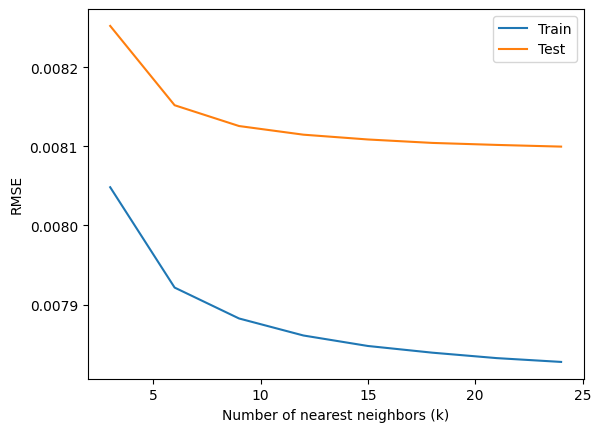

([0.008048315813386381,
  0.007921563772777024,
  0.007882540202367637,
  0.007861034524445502,
  0.007847796316826422,
  0.007839334145523355,
  0.007832462330618859,
  0.007827652430881309],
 [0.008252076675815087,
  0.00815189395065606,
  0.008125620340576518,
  0.008114690510848224,
  0.008108643673803824,
  0.008104293548197687,
  0.008101767326184197,
  0.008099632494657137])

In [28]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

def sparse_rmse(actual, test):
    # Get the indices of the non-zero elements in actual
    non_zero_indices = np.nonzero(actual)
    
    # Extract the corresponding values from actual and test
    actual_non_zero = actual[non_zero_indices]
    test_non_zero = test[non_zero_indices]
    
    # Compute the mean squared error of the non-zero elements in actual
    mse = np.mean(np.square(actual_non_zero - np.where(actual_non_zero, test_non_zero, 0)))
    
    # Compute the root mean squared error
    rmse = np.sqrt(mse)
    
    return rmse
def user_based_collaborative_filtering(train_matrix,test_matrix, k_values):
    # Convert the train and test sets to sparse matrices
    learn_matrix, train_matrix= split_matrix(train_matrix,test_ratio=0.3)
    train_sparse = csr_matrix(train_matrix)
    test_sparse = csr_matrix(test_matrix)
    learn_sparse = csr_matrix(learn_matrix)
    # List to store the RMSE values for different k values for train and test sets
    rmse_train = []
    rmse_test = []

    # Find the k most similar users for each user and predict the ratings for the train and test sets
    for k in k_values:
        knn_model = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='auto')
        knn_model.fit(learn_sparse)
        distances, indices = knn_model.kneighbors(learn_sparse, return_distance=True)
        
        # Predict the ratings for the train set
        train_predictions = []
        for i in range(train_matrix.shape[0]):
            train_indices = train_sparse[i].nonzero()[1]
            train_ratings = train_sparse[i, train_indices].toarray().squeeze()
            similar_users = indices[i, 1:]
            similarity_scores = distances[i, 1:]
            neighbor_ratings = learn_sparse[similar_users][:, train_indices].toarray()
            if neighbor_ratings.size > 0:
                predicted_ratings = np.sum(neighbor_ratings * similarity_scores.reshape(-1, 1), axis=0) / np.sum(similarity_scores)
            else:
                predicted_ratings = np.zeros(len(train_indices))
            train_predictions.append(predicted_ratings)
        train_predictions = np.concatenate(train_predictions)
        train_ratings = train_matrix[np.nonzero(train_matrix)]
        rmse_train.append(sparse_rmse(train_ratings, train_predictions))

        # Predict the ratings for the test set
        test_predictions = []
        for i in range(train_matrix.shape[0]):
            test_indices = test_sparse[i].nonzero()[1]
            test_ratings = test_sparse[i, test_indices].toarray().squeeze()
            similar_users = indices[i, 1:]
            similarity_scores = distances[i, 1:]
            neighbor_ratings = train_sparse[similar_users][:, test_indices].toarray()
            if neighbor_ratings.size > 0:
                predicted_test_ratings = np.sum(neighbor_ratings * similarity_scores.reshape(-1, 1), axis=0) / np.sum(similarity_scores)
            else:
                predicted_test_ratings = np.zeros(len(test_indices))
            test_predictions.append(predicted_test_ratings)
        test_predictions = np.concatenate(test_predictions)
        test_ratings = test_matrix[np.nonzero(test_matrix)]
        rmse_test.append(sparse_rmse(test_ratings, test_predictions))
        print('\r k = %d, RMSE on train: %f, test: %f' % (k, rmse_train[-1], rmse_test[-1]))

    # Plot the RMSE values for different k values for train and test sets
    plt.plot(k_values, rmse_train, label='Train')
    plt.plot(k_values, rmse_test, label='Test')
    plt.xlabel('Number of nearest neighbors (k)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    
    return rmse_train, rmse_test
user_based_collaborative_filtering(train_matrix, test_matrix, k_values=range(3,25,3))

In [ ]:
user_based_collaborative_filtering(train_matrix.T, test_matrix.T, k_values=range(3,25,3))

C:\Users\PC\AppData\Local\Temp\ipykernel_13900\4002780050.py:44: RuntimeWarning: invalid value encountered in divide
  predicted_ratings = np.sum(neighbor_ratings * similarity_scores.reshape(-1, 1), axis=0) / np.sum(similarity_scores)
C:\Users\PC\AppData\Local\Temp\ipykernel_13900\4002780050.py:61: RuntimeWarning: invalid value encountered in divide
  predicted_test_ratings = np.sum(neighbor_ratings * similarity_scores.reshape(-1, 1), axis=0) / np.sum(similarity_scores)


 k = 3, RMSE on train: nan, test: nan


MemoryError: Unable to allocate 1.00 GiB for an array with shape (2081, 64467) and data type float64